### 匯入套件與函數

In [1]:
import torch
import cv2
import os
import numpy as np
from torchvision import transforms
from PIL import Image
import torch.nn as nn
import math
import torch.nn.functional as F
from io import BytesIO
import tarfile
import tensorflow as tf
from six.moves import urllib

### segmentation - DeepLabV3+ model loading function

In [2]:
class DeepLabModel(object):
    INPUT_TENSOR_NAME = 'ImageTensor:0'
    OUTPUT_TENSOR_NAME = 'SemanticPredictions:0'
    INPUT_SIZE = 513 #圖片長寬
    FROZEN_GRAPH_NAME = 'frozen' #_inference_graph
    def __init__(self, tarball_path):
        self.graph = tf.Graph()
        graph_def = None
        tar_file = tarfile.open(tarball_path)
        for tar_info in tar_file.getmembers():
            if self.FROZEN_GRAPH_NAME in os.path.basename(tar_info.name):
                file_handle = tar_file.extractfile(tar_info)
                graph_def = tf.GraphDef.FromString(file_handle.read())
                break
        tar_file.close()  
        if graph_def is None:
            raise RuntimeError('Cannot find inference graph in tar archive.')
        with self.graph.as_default():
            tf.import_graph_def(graph_def, name='')
        self.sess = tf.Session(graph=self.graph)
    def run(self, image):
        width, height = image.size
        resize_ratio = 1.0 * self.INPUT_SIZE / max(width, height)
        target_size = (int(resize_ratio * width), int(resize_ratio * height))
        resized_image = image.convert('RGB').resize(target_size, Image.ANTIALIAS)
        batch_seg_map = self.sess.run(
            self.OUTPUT_TENSOR_NAME,
            feed_dict={self.INPUT_TENSOR_NAME: [np.asarray(resized_image)]})
        seg_map = batch_seg_map[0]
        return resized_image, seg_map 

### segmentation - DeepLabV3+ result function

In [3]:
def deeplabv3plus(photo_input, website = False):
    MODEL = MODEL_xception65_trainval
    if website:
        try:
            f = urllib.request.urlopen(photo_input)
            jpeg_str = f.read()
            original_im = Image.open(BytesIO(jpeg_str))
        except IOError:
            print('Cannot retrieve image. Please check url: ' + photo_input)
            return
    else : 
        original_im = Image.open(photo_input)
        
    width, height = original_im.size
    resized_im, seg_map = MODEL.run(original_im)
    cm = seg_map
    img = np.array(resized_im)
    rows = cm.shape[0]
    cols = cm.shape[1]
    
    img_seq = img.copy()
    img_seq[cm==0] = np.array([255, 255,255], dtype='uint8') 
    img_seq = Image.fromarray(img_seq).resize((width, height),Image.ANTIALIAS) 
    
    img_mask = img.copy()
    img_mask[cm==0] = np.array([0, 0,0], dtype='uint8') 
    img_mask[cm!=0] = np.array([255, 255,255], dtype='uint8') 
    img_mask = Image.fromarray(img_mask).resize((width, height),Image.ANTIALIAS)

    return img_seq, img_mask, original_im

### trimap - trimap result function

In [4]:
def trimap(image, size, erosion=False):
    if len(image.shape)>2:
        image = image[:, :, 0]
        
    row = image.shape[0];
    col = image.shape[1];

    pixels = 2*size + 1;                                     ## Double and plus 1 to have an odd-sized kernel
    kernel = np.ones((pixels,pixels),np.uint8)               ## How many pixel of extension do I get

    if erosion is not False:
        erosion = int(erosion)
        erosion_kernel = np.ones((3,3), np.uint8)                     ## Design an odd-sized erosion kernel
        image = cv2.erode(image, erosion_kernel, iterations=erosion)  ## How many erosion do you expect
        image = np.where(image > 0, 255, image)                       ## Any gray-clored pixel becomes white (smoothing)
        # Error-handler to prevent entire foreground annihilation
        if cv2.countNonZero(image) == 0:
            print("ERROR: foreground has been entirely eroded");
            sys.exit();

    dilation  = cv2.dilate(image, kernel, iterations = 1)

    dilation  = np.where(dilation == 255, 128, dilation) 	## WHITE to GRAY
    remake    = np.where(dilation != 128, 0, dilation)		## Smoothing
    remake    = np.where(image > 128, 200, dilation)		## mark the tumor inside GRAY

    remake    = np.where(remake < 128, 0, remake)		## Embelishment
    remake    = np.where(remake > 200, 0, remake)		## Embelishment
    remake    = np.where(remake == 200, 255, remake)		## GRAY to WHITE
 
    for i in range(0,row):
        for j in range (0,col):
            if (remake[i,j] != 0 and remake[i,j] != 255):
                remake[i,j] = 128;
    print("generate trimap(size: " + str(size) + ", erosion: " + str(erosion) + ")")
    return Image.fromarray(remake)

### matting - deepmatting model loading function

In [5]:
class VGG16(nn.Module):
    def __init__(self, stage):#args
        super(VGG16, self).__init__()
        self.stage = stage        
        self.conv1_1 = nn.Conv2d(4, 64, kernel_size=3,stride = 1, padding=1,bias=True)
        self.conv1_2 = nn.Conv2d(64, 64, kernel_size=3,stride = 1, padding=1,bias=True)
        self.conv2_1 = nn.Conv2d(64, 128, kernel_size=3, padding=1,bias=True)
        self.conv2_2 = nn.Conv2d(128, 128, kernel_size=3, padding=1,bias=True)
        self.conv3_1 = nn.Conv2d(128, 256, kernel_size=3, padding=1,bias=True)
        self.conv3_2 = nn.Conv2d(256, 256, kernel_size=3, padding=1,bias=True)
        self.conv3_3 = nn.Conv2d(256, 256, kernel_size=3, padding=1,bias=True)
        self.conv4_1 = nn.Conv2d(256, 512, kernel_size=3, padding=1,bias=True)
        self.conv4_2 = nn.Conv2d(512, 512, kernel_size=3, padding=1,bias=True)
        self.conv4_3 = nn.Conv2d(512, 512, kernel_size=3, padding=1,bias=True)
        self.conv5_1 = nn.Conv2d(512, 512, kernel_size=3, padding=1,bias=True)
        self.conv5_2 = nn.Conv2d(512, 512, kernel_size=3, padding=1,bias=True)
        self.conv5_3 = nn.Conv2d(512, 512, kernel_size=3, padding=1,bias=True)
        self.conv6_1 = nn.Conv2d(512, 512, kernel_size=3, padding=1,bias=True)        
        self.deconv6_1 = nn.Conv2d(512, 512, kernel_size=1,bias=True)
        self.deconv5_1 = nn.Conv2d(512, 512, kernel_size=5, padding=2,bias=True)
        self.deconv4_1 = nn.Conv2d(512, 256, kernel_size=5, padding=2,bias=True)
        self.deconv3_1 = nn.Conv2d(256, 128, kernel_size=5, padding=2,bias=True)
        self.deconv2_1 = nn.Conv2d(128, 64, kernel_size=5, padding=2,bias=True)
        self.deconv1_1 = nn.Conv2d(64, 64, kernel_size=5, padding=2,bias=True)        
        self.deconv1 = nn.Conv2d(64, 1, kernel_size=5, padding=2,bias=True)
        
    def forward(self, x):
        # Stage 1
        x11 = F.relu(self.conv1_1(x))
        x12 = F.relu(self.conv1_2(x11))
        x1p, id1 = F.max_pool2d(x12,kernel_size=(2,2), stride=(2,2),return_indices=True)

        # Stage 2
        x21 = F.relu(self.conv2_1(x1p))
        x22 = F.relu(self.conv2_2(x21))
        x2p, id2 = F.max_pool2d(x22,kernel_size=(2,2), stride=(2,2),return_indices=True)

        # Stage 3
        x31 = F.relu(self.conv3_1(x2p))
        x32 = F.relu(self.conv3_2(x31))
        x33 = F.relu(self.conv3_3(x32))
        x3p, id3 = F.max_pool2d(x33,kernel_size=(2,2), stride=(2,2),return_indices=True)

        # Stage 4
        x41 = F.relu(self.conv4_1(x3p))
        x42 = F.relu(self.conv4_2(x41))
        x43 = F.relu(self.conv4_3(x42))
        x4p, id4 = F.max_pool2d(x43,kernel_size=(2,2), stride=(2,2),return_indices=True)

        # Stage 5
        x51 = F.relu(self.conv5_1(x4p))
        x52 = F.relu(self.conv5_2(x51))
        x53 = F.relu(self.conv5_3(x52))
        x5p, id5 = F.max_pool2d(x53,kernel_size=(2,2), stride=(2,2),return_indices=True)

        # Stage 6
        x61 = F.relu(self.conv6_1(x5p))

        # Stage 6d
        x61d = F.relu(self.deconv6_1(x61))

        # Stage 5d
        x5d = F.max_unpool2d(x61d,id5, kernel_size=2, stride=2)
        x51d = F.relu(self.deconv5_1(x5d))

        # Stage 4d
        x4d = F.max_unpool2d(x51d, id4, kernel_size=2, stride=2)
        x41d = F.relu(self.deconv4_1(x4d))

        # Stage 3d
        x3d = F.max_unpool2d(x41d, id3, kernel_size=2, stride=2)
        x31d = F.relu(self.deconv3_1(x3d))

        # Stage 2d
        x2d = F.max_unpool2d(x31d, id2, kernel_size=2, stride=2)
        x21d = F.relu(self.deconv2_1(x2d))

        # Stage 1d
        x1d = F.max_unpool2d(x21d, id1, kernel_size=2, stride=2)
        x12d = F.relu(self.deconv1_1(x1d))

        # Should add sigmoid? github repo add so.
        raw_alpha = self.deconv1(x12d)
        pred_mattes = F.sigmoid(raw_alpha)

        if self.stage <= 1:
            return pred_mattes, 0

        # Stage2 refine conv1
        refine0 = torch.cat((x[:, :3, :, :], pred_mattes),  1)
        refine1 = F.relu(self.refine_conv1(refine0))
        refine2 = F.relu(self.refine_conv2(refine1))
        refine3 = F.relu(self.refine_conv3(refine2))

        pred_refine = self.refine_pred(refine3)
        pred_alpha = F.sigmoid(raw_alpha + pred_refine)

        return pred_mattes, pred_alpha

In [6]:
def loading_model():
    # init model
    resume = "stage1_sad_54.4.pth"
    model = VGG16(stage = 1)
    ckpt = torch.load(resume, map_location=torch.device('cpu'))
    model.load_state_dict(ckpt['state_dict'], strict=True)
    return model

### matting - deepmatting image transform function

In [7]:
def compute_gradient(img):
    x = cv2.Sobel(img, cv2.CV_16S, 1, 0)
    y = cv2.Sobel(img, cv2.CV_16S, 0, 1)
    absX = cv2.convertScaleAbs(x)
    absY = cv2.convertScaleAbs(y)
    grad = cv2.addWeighted(absX, 0.5, absY, 0.5, 0)
    grad=cv2.cvtColor(grad, cv2.COLOR_BGR2GRAY)
    return grad

# inference once for image, return numpy
def inference_once(model, scale_img, scale_trimap, aligned=True):
    size_h = 320
    size_w = 320
    if aligned:
        assert(scale_img.shape[0] == size_h)
        assert(scale_img.shape[1] == size_w)

    normalize = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean = [0.485, 0.456, 0.406],std = [0.229, 0.224, 0.225])
    ])

    scale_img_rgb = cv2.cvtColor(scale_img, cv2.COLOR_BGR2RGB)
    # first, 0-255 to 0-1
    # second, x-mean/std and HWC to CHW
    tensor_img = normalize(scale_img_rgb).unsqueeze(0)

    scale_grad = compute_gradient(scale_img)
    tensor_trimap = torch.from_numpy(scale_trimap.astype(np.float32)[np.newaxis, np.newaxis, :, :])
    tensor_grad = torch.from_numpy(scale_grad.astype(np.float32)[np.newaxis, np.newaxis, :, :])

    input_t = torch.cat((tensor_img, tensor_trimap / 255.), 1)

    pred_mattes, _ = model(input_t)
    pred_mattes = pred_mattes.data
    pred_mattes = pred_mattes.numpy()[0, 0, :, :]
    return pred_mattes

# forward a whole image
def inference_img_whole(model, img, trimap):
    h, w, c = img.shape
    max_size = 1600
    new_h = min(max_size, h - (h % 32))
    new_w = min(max_size, w - (w % 32))

    # resize for network input, to Tensor
    scale_img = cv2.resize(img, (new_w, new_h), interpolation=cv2.INTER_LINEAR)
    scale_trimap = cv2.resize(trimap, (new_w, new_h), interpolation=cv2.INTER_LINEAR)

    pred_mattes = inference_once(model, scale_img, scale_trimap, aligned=False)

    # resize to origin size
    origin_pred_mattes = cv2.resize(pred_mattes, (w, h), interpolation = cv2.INTER_LINEAR)
    assert(origin_pred_mattes.shape == trimap.shape)
    return origin_pred_mattes

def composite4(fg, bg, a, w, h):
    fg = np.array(fg, np.float32)
    bg_h, bg_w = bg.shape[:2]
    x = 0
    if bg_w > w:
        x = np.random.randint(0, bg_w - w)
    y = 0
    if bg_h > h:
        y = np.random.randint(0, bg_h - h)
    bg = np.array(bg[y:y + h, x:x + w], np.float32)
    alpha = np.zeros((h, w, 1), np.float32)
    alpha[:, :, 0] = a
    im = alpha * fg + (1 - alpha) * bg
    im = im.astype(np.uint8)
    return im

### matting - deepmatting result function

In [8]:
def matting_result(pic_input, tri_input):
    model_input = model_matting
    original_im = np.array(pic_input)[:, :, :3]
    trimap_im = np.array(tri_input)    
    if len(trimap_im.shape)>2:
        trimap_im = trimap_im[:, :, 0]
    with torch.no_grad():
        alpha = inference_img_whole(model_input, original_im, trimap_im)
    
    alpha[trimap_im == 0] = 0.0
    alpha[trimap_im == 255] = 1.0
    h, w = original_im.shape[:2]
    new_bg = np.array(np.full((h,w,3), 255), dtype='uint8')
    im = composite4(original_im, new_bg, alpha, w, h)
    im = Image.fromarray(im)
    return im

### segmentation

In [9]:
MODEL_xception65_trainval = DeepLabModel("deeplabv3_pascal_trainval_2018_01_04.tar.gz")
print("deeplabv3+ model loading")
result_segmentation = deeplabv3plus('06.jpg')
print("deeplabv3+ result")

deeplabv3+ model loading
deeplabv3+ result


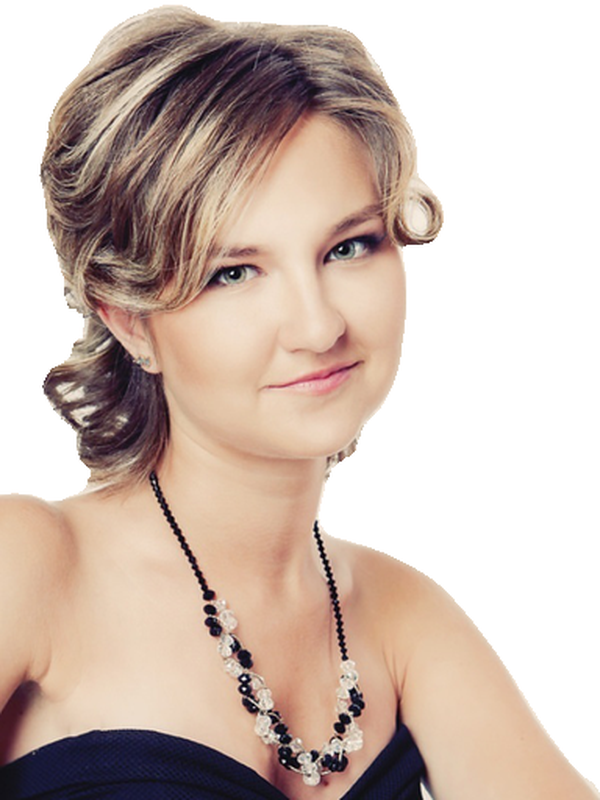

In [10]:
# 0:segmentation的結果
result_segmentation[0]

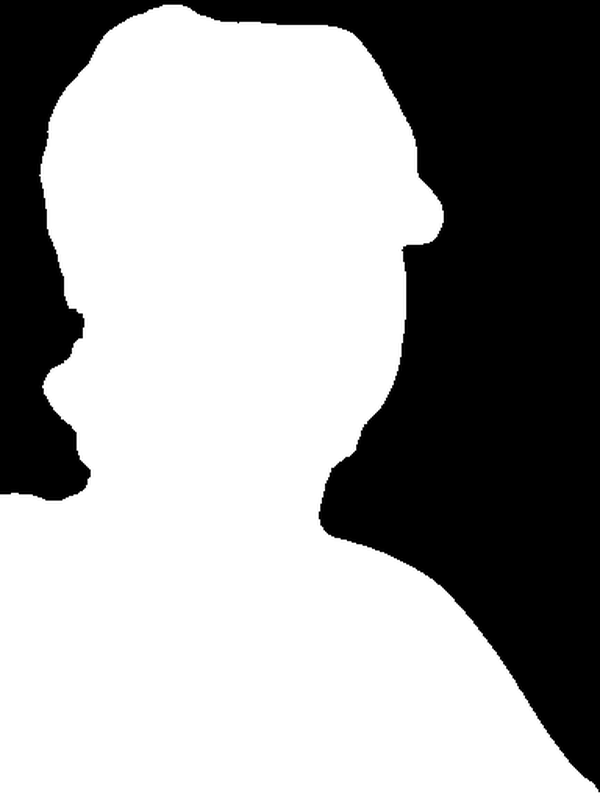

In [11]:
# 1:segmentation產生的mask
result_segmentation[1]

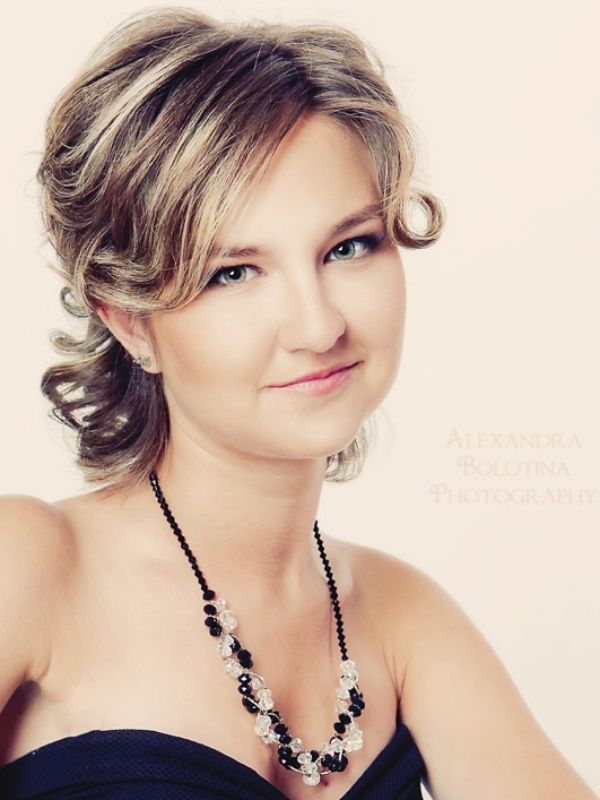

In [12]:
# 2:原圖
result_segmentation[2]

### trimap

generate trimap(size: 30, erosion: 10)


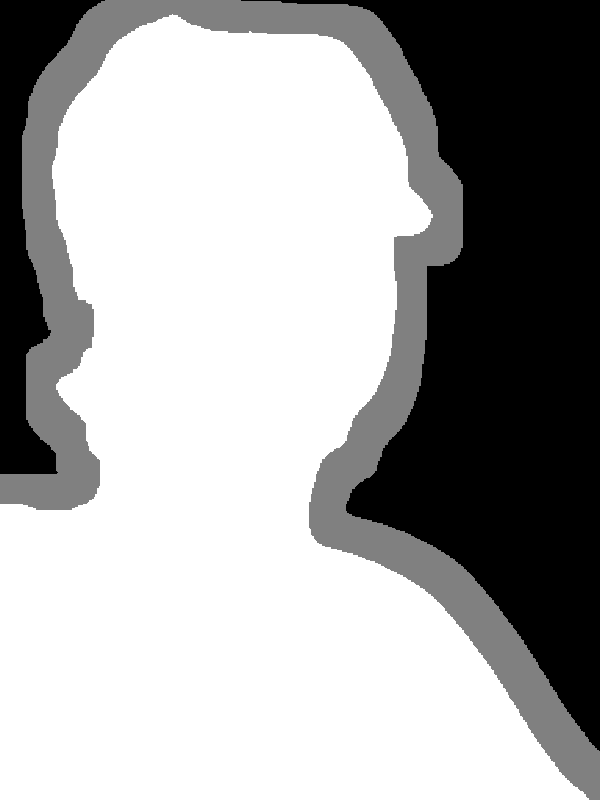

In [13]:
# 將segmentation產生的mask依內縮與外擴的單位，生成trimap圖
# erosion內縮單位 size 外擴單位
result_trimap = trimap(image = np.array(result_segmentation[1]), 
                       size = 30, 
                       erosion = 10)
result_trimap

### matting

In [14]:
model_matting = loading_model()
print("matting model loading")
result_matting = matting_result(pic_input = result_segmentation[2], 
                                tri_input = result_trimap)
print("matting result")

matting model loading
matting result


/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1569: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


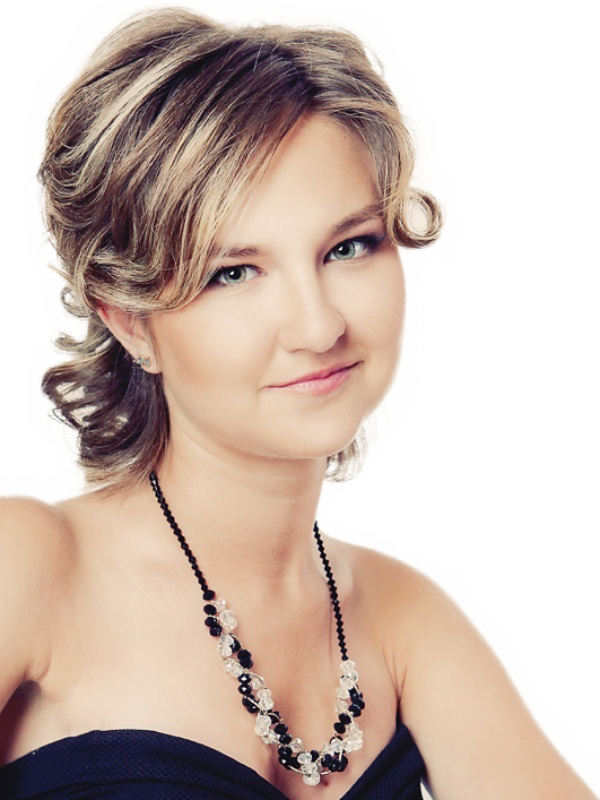

In [15]:
result_matting

### try another trimap

generate trimap(size: 50, erosion: 30)


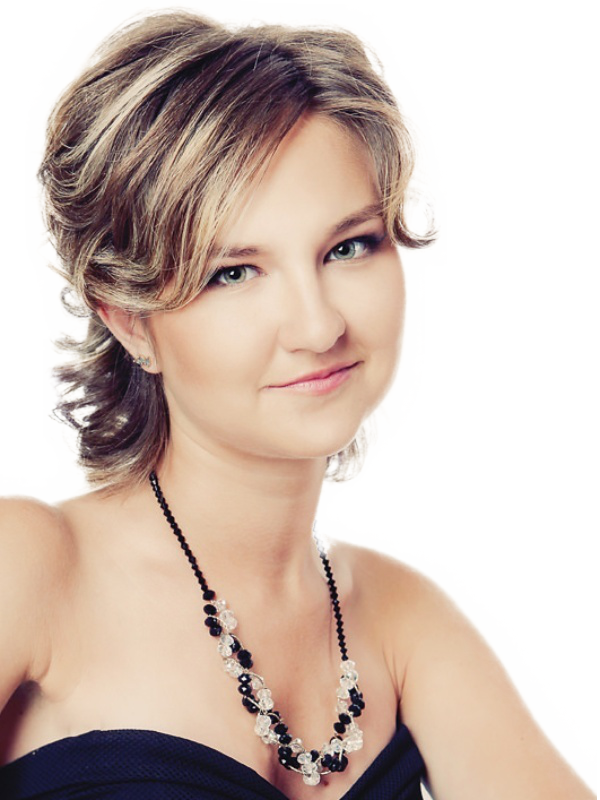

In [16]:
result_trimap_50_30 = trimap(image = np.array(result_segmentation[1]), 
                             size = 50, 
                             erosion = 30)
result_matting_50_30 = matting_result(pic_input = result_segmentation[2], 
                                      tri_input = result_trimap_50_30)
result_matting_50_30